In [4]:
import pandas
import numpy as np
from rootpy.io import root_open

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [5]:
%env OMP_NUM_THREADS=4

env: OMP_NUM_THREADS=4


In [6]:
%load_ext autoreload
%autoreload 2

import root_numpy

Класс, который соответсвует области калориметра, проверяяет, не выскакивает ли квадрат за калориметр

In [7]:
class Bound(object):
    def __init__(self, left=0, right=0, bottom=0, top=0, multiplier = 1, divider = 1):
        self.left = left
        self.right = right
        self.top = top
        self.bottom = bottom
        self.multiplier = multiplier
        self.divider = divider

class Area(object):
    def __init__(self):
        self.inner = Bound()
        self.outer = Bound()
    def get_inner_bound():
        return self.inner
    def get_outer_bound():
        return self.outer
    
    def get_function_selector(self, ind):
        return {1:self.get_inner_bound, 2:self.get_outer_bound}[ind]
        
    def OverOut(self, x1, x2):
        return ((x1 >=self.outer.right - 1 or x1<=self.outer.left + 1) or (x2 >= self.outer.top - 1 or x2<=self.outer.bottom + 1))
    def OverIn(self, x1, x2):
        #print self.inner.left, self.inner.right, self.inner.bottom,  self.inner.top
        #print x1, x2
        #print (x1 >=self.inner.left - 1 and x1<=self.inner.right + 1)
        #print (x2 >= self.inner.bottom - 1 and x2<=self.inner.top + 1)
        return ((x1 >=self.inner.left - 1 and x1<=self.inner.right + 1) and (x2 >= self.inner.bottom - 1 and x2<=self.inner.top + 1))
    def InCalorimeter(self, x1, x2):        
        return not(self.OverOut(x1,x2)) and not(self.OverIn(x1,x2))
        
    def reconstr_param(self, x1, x2, is_outer):
        answ = []
        axes = {'x':x1, 'y':x2}
        if (is_outer == 1):
            coordinates = {'left':(x1-1, x2), 'bottom':(x1, x2-1), 'top':(x1, x2+1), 'right':(x1+1, x2)}
            big_dict = {'y':{"top":self.outer.top, "bottom":self.outer.bottom}, 'x':{"left":self.outer.left, "right":self.outer.right}}
        else:
            coordinates = {'left':(x1+1, x2), 'bottom':(x1, x2+1), 'top':(x1, x2-1), 'right':(x1-1, x2)}
            big_dict = {'y':{"top":self.inner.top, "bottom":self.inner.bottom}, 'x':{"left":self.inner.left, "right":self.inner.right}}
        for elem in big_dict:
            for side in big_dict[elem]: #elem - x или y # короче это например space.outer.top - elem[7] - 0 или 1, отстутп   
                dist = abs(big_dict[elem][side] - axes[elem])
                if (dist <= 1):
                    answ = [(coordinates[side][0], coordinates[side][1], (2-ind), side) for ind in range(2-dist)] #dist 0 или 1
                    return answ
        return []

class Inner(Area):
    def __init__(self):
        self.inner = Bound(25,38,23,40,1,1)
        self.outer = Bound(14,49,8,55,2,3) #из 2-го в 1ый
        self.multiplier_in = 1
        self.divider_in = 1
        self.multiplier_out = 2
        self.divider_out = 3
    
    def NotInCalorimeter(self, x1, x2):  #x1- elem6, x2-elem7
        return self.OverIn(x1, x2)
        #return ((x1 >=self.inner.left + 1 and x1<=self.inner.right - 1) and (x2 >= self.inner.bottom + 1 and x2<=self.inner.top - 1)) #for Inner region "True" if in center hole
        
    
class Middle(Area):
    def __init__(self):
        self.inner = Bound(19,44,15,48,3,2)#из 1-го в 2-ый
        self.outer = Bound(12,51,0,63,1,2)# из 1 в 0-ый
    def NotInCalorimeter(self, x1, x2):  #x1- elem6, x2-elem7 for Inner region "True" if in center hole 
        return False #every square could be restore
    
class Outer(Area):
    def __init__(self):
        self.inner = Bound(21,42,15,48,2,1)
        self.outer = Bound(0,63,6,57,1,1)
    def NotInCalorimeter(self, x1, x2):  #x1- elem6, x2-elem7 for Inner region "True" if in center hole 
        return self.OverOut(x1, x2)     

In [8]:
abs(-3)

3

In [9]:
areas = {2:Inner(), 1:Middle(), 0:Outer()}
space = areas[1]
print space.outer.bottom
print space.outer.bottom + 1 >= 15 >= space.outer.bottom - 1 
print (space.inner.left<=22<=space.inner.right)

0
False
True


In [10]:
import recover

In [11]:
#axis - left, right, top or bottom
#n_area_bound - boundary layer from neighbour area (inner or outer, depends on)
# n_ecal_data, n_ps_data - matrix of neighbour area (counted outside)

make_vector = {'left':recover.make_vector_left, \
               'right':recover.make_vector_right,\
               'top':recover.make_vector_top,\
               'bottom':recover.make_vector_bottom}

assigment = {'left':recover.assigment_left,\
             'right':recover.assigment_right,\
             'top':recover.assigment_top,\
              'bottom':recover.assigment_bottom}


def reconstruct_new(cell_x, cell_y, distance_, axis, area_bound, n_area_bound, ecal_square, ps_square, n_ecal_data, n_ps_data, type_='norm'):
    ecal_data_groups = n_ecal_data.groupby(("col","row")) # y - колонка, x - ряд
    ps_data_groups = n_ps_data.groupby(("col","row"))
    if (type_ == 'norm'):
        multiplier,divider = area_bound.multiplier, area_bound.divider
    else:
        multiplier,divider = area_bound.multiplier, area_bound.divider
    #print "multiplier, divider", multiplier,divider
    vect_,vect_ps = make_vector[axis](cell_x, cell_y, area_bound, n_area_bound, ecal_data_groups, ps_data_groups,multiplier,divider)
    assigment[axis](ecal_square, ps_square, vect_, vect_ps, distance_, type_)
    #print "square after", ecal_square
    return ecal_square, ps_square

def append_(X_list, y_list, area_list,  X_, y_, area_tuple):
    X_list.append(np.concatenate((X_[0].reshape((1,5,5)), X_[1].reshape((1,5,5))), 0))
    y_list.append(y_)
    area_list.append(area_tuple)

In [12]:
number_of_samples = {'0':{'inner':0, 'outer':0, 'simple': 0}, '1':{'inner':0, 'outer':0, 'simple': 0}, '2':{'inner':0, 'outer':0, 'simple': 0}}
number_of_samples

{'0': {'inner': 0, 'outer': 0, 'simple': 0},
 '1': {'inner': 0, 'outer': 0, 'simple': 0},
 '2': {'inner': 0, 'outer': 0, 'simple': 0}}

## Destribution X, Y 

In [13]:
destibution_dict0 = {'x':[],'y':[]}
destibution_dict1 = {'x':[],'y':[]}
destibution_dict2 = {'x':[],'y':[]}

def count_distribution(samples, area, is_photon, need_hypo):
    icount = 0
    counter = 0
    for string_ in samples:
        i = 0
        print string_
        f = root_open(string_)
        if (is_photon):
            data = root_numpy.root2array(string_, 
                                 treename='dumpEcal/PhotonAreas')
        else:
            data = root_numpy.root2array(string_, 
                                 treename='dumpEcal/BPi0Areas')   
        space = areas[area]
        dataframe = pandas.DataFrame(root_numpy.root2array(string_, treename='dumpEcal/EcalDigis'))
        groups = dataframe.groupby(("eventID","area"))
        dataframe_ps = pandas.DataFrame(root_numpy.root2array(string_, treename='dumpEcal/PSDigis'))
        groups_ps = dataframe_ps.groupby(("eventID","area"))
        
        if (i%5000 == 0):
            print i
        space = areas[area]
        print len(data)
        for indd, elem in enumerate(data):
            photon = 100
            if elem[5] != area:
                continue
           
            if (space.NotInCalorimeter(elem[6],elem[7])):
                if area == 2:
                    counter+=1
                continue
            if (need_hypo):
                photon = elem[10]
            if (elem[1] > 2000 and photon > -99):
                icount += 1 
                if area == 0:
                    destibution_dict0['x'].append(elem[6])
                    destibution_dict0['y'].append(elem[7])
                if area == 1:
                    destibution_dict1['x'].append(elem[6])
                    destibution_dict1['y'].append(elem[7])
                if area == 2:
                    destibution_dict2['x'].append(elem[6])
                    destibution_dict2['y'].append(elem[7])
    print icount

In [58]:
print counter
print map(len,[destibution_dict0['x'], destibution_dict1['x'], destibution_dict2['x']])
print map(len,[destibution_dict0['y'], destibution_dict1['y'], destibution_dict2['y']])

0
[54910, 0, 0]
[54910, 0, 0]


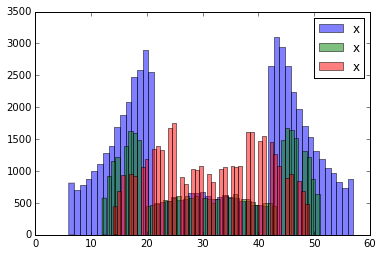

In [43]:
from matplotlib import pyplot

plt.hist(destibution_dict0['x'], bins = 50, alpha=0.5, label='x')
plt.hist(destibution_dict1['x'], bins = 50, alpha=0.5, label='x')
plt.hist(destibution_dict2['x'], bins = 50, alpha=0.5, label='x')
pyplot.legend(loc='upper right')
pyplot.show()

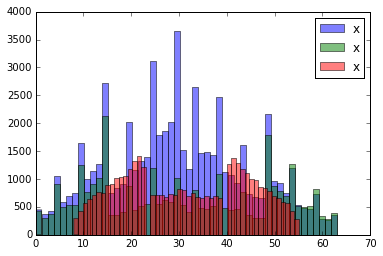

In [44]:
plt.hist(destibution_dict0['y'], bins = 50, alpha=0.5, label='x')
plt.hist(destibution_dict1['y'], bins = 50, alpha=0.5, label='x')
plt.hist(destibution_dict2['y'], bins = 50, alpha=0.5, label='x')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
destibution_dict

## Create samples ##

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

def append_(X_list, y_list, area_list,  X_, y_, area_tuple):
    X_list.append(np.concatenate((X_[0].reshape((1,5,5)), X_[1].reshape((1,5,5))), 0))
    y_list.append(y_)
    area_list.append(area_tuple)

x_6 = []
x_7 = []
sq_old = []
sq_new = []

areas = {2:Inner(), 1:Middle(), 0:Outer()}

number_of_samples = {'0':{'simple':0, 'inner':0, 'outer':0}, '1':{'simple':0, 'inner':0, 'outer':0}, '2':{'simple':0, 'inner':0, 'outer':0}}
counter = 0

def make_sample_new(samples, area, is_photon, need_hypo):   #samples - list of root-sample , 
                                                        #is_photon - '1' if photon, '0' if pi0, hypo - hypothesis, 
                                                        #need_hypo - is hypothethis take into account
    square_X_5_All = []
    square_X_5_reconstruct_inner = []
    square_X_5_reconstruct_outer = []
    square_y = []
    square_y_reconstruct_inner = []
    square_y_reconstruct_outer = []
    area_list = []
    area_list_reconstruct_inner = []
    area_list_reconstruct_outer = []
    area_tuple = (area, 0)
    area_tuple_reconstr_inner = (area, 1)
    area_tuple_reconstr_outer = (area, 2)
    counter = 0
    u = 0
    for string_ in samples:
        i = 0
        print string_
        f = root_open(string_)
        if (is_photon):
            data = root_numpy.root2array(string_, 
                                 treename='dumpEcal/PhotonAreas')
        else:
            data = root_numpy.root2array(string_, 
                                 treename='dumpEcal/BPi0Areas')   
        space = areas[area]
        print space.inner.top
        dataframe = pandas.DataFrame(root_numpy.root2array(string_, treename='dumpEcal/EcalDigis'))
        groups = dataframe.groupby(("eventID","area"))
        dataframe_ps = pandas.DataFrame(root_numpy.root2array(string_, treename='dumpEcal/PSDigis'))
        groups_ps = dataframe_ps.groupby(("eventID","area"))
        
        if (i%5000 == 0):
            print i
        
        print len(data)
        for indd, elem in enumerate(data):
            a = np.array(elem[8]).reshape((1,5,5))
            b = np.array(elem[9]).reshape((1,5,5))
            id_ = elem[0]
            photon = 100
            if (need_hypo):
                photon = elem[10]


            try:
                dataframe1 = groups.get_group((id_,area))
            except:
                continue
            if (len(dataframe1) == 0 or elem[5] != area):
                continue
                
            if (space.NotInCalorimeter(elem[6],elem[7])):
                if area == 2:
                    if (elem[1] > 2000 and photon > -99):
                        number_of_samples[str(area)]['inner'] += 1
                        append_(square_X_5_reconstruct_inner, square_y_reconstruct_inner, area_list_reconstruct_inner, (a, b), is_photon, area_tuple_reconstr_inner)
                        counter+=1
                    continue
                else:
                    continue
                
            if(space.OverIn(elem[6], elem[7])): #in
                n_space = areas[area+1]
                try:
                    dataframen = groups.get_group((id_,area+1))
                    dataframe1_psn = groups_ps.get_group((id_,area+1))
                except:
                    continue
                answ = space.reconstr_param(elem[6], elem[7], 0)
                for param in answ:
                    a,b = reconstruct_new(param[0], param[1], param[2], param[3] ,space.inner, n_space.outer, a.reshape((5,5)), b.reshape((5,5)), dataframen,  dataframe1_psn, 'inv')
                if (elem[1] > 2000 and photon > -99):
                    number_of_samples[str(area)]['inner'] += 1
                    append_(square_X_5_reconstruct_inner, square_y_reconstruct_inner, area_list_reconstruct_inner, (a, b), is_photon, area_tuple_reconstr_inner)
                
            elif(space.OverOut(elem[6], elem[7])): #out
                #print "out", elem[6], elem[7]
                n_space = areas[area-1]
                try:
                    dataframen = groups.get_group((id_,area-1))
                    dataframe1_psn = groups_ps.get_group((id_,area-1))
                except:
                    continue
                answ = space.reconstr_param(elem[6], elem[7], 1)
                for param in answ:
                    a,b = reconstruct_new(param[0], param[1], param[2], param[3] ,space.outer, n_space.inner, a.reshape((5,5)), b.reshape((5,5)), dataframen,  dataframe1_psn)
                if (elem[1] > 2000 and photon > -99): 
                    number_of_samples[str(area)]['outer'] += 1
                    append_(square_X_5_reconstruct_outer, square_y_reconstruct_outer, area_list_reconstruct_outer, (a, b), is_photon, area_tuple_reconstr_outer)
            else:
                if (elem[1] > 2000 and photon > -99):
                    number_of_samples[str(area)]['simple'] += 1
                    append_(square_X_5_All, square_y, area_list, (a, b), is_photon, area_tuple)

    return square_X_5_All, square_X_5_reconstruct_inner, square_X_5_reconstruct_outer, square_y, square_y_reconstruct_inner, square_y_reconstruct_outer, area_list, area_list_reconstruct_inner, area_list_reconstruct_outer 

In [15]:
print 6

6


In [ ]:
tup_pi0_list = []

for i in range(3):
    square_X_5_All, square_X_5_reconstruct_inner, square_X_5_reconstruct_outer, square_y, square_y_reconstruct_inner, square_y_reconstruct_outer, area_list, area_list_reconstruct_inner, area_list_reconstruct_outer = make_sample_new(["../../../data_ROOT/Pi0s_j29_tuple.root", "../../../data_ROOT/Pi0s_j31_tuple.root", "../../../data_ROOT/Pi0s_j35_tuple.root", "../../../data_ROOT/Pi0s_j34_tuple.root"],i,0,1)
    tup_pi0_list.append([square_X_5_All, square_X_5_reconstruct_inner, square_X_5_reconstruct_outer, square_y, square_y_reconstruct_inner, square_y_reconstruct_outer, area_list, area_list_reconstruct_inner, area_list_reconstruct_outer])

../../../data_ROOT/Pi0s_j29_tuple.root
48
0
7719
../../../data_ROOT/Pi0s_j31_tuple.root
48
0
7904
../../../data_ROOT/Pi0s_j35_tuple.root
48
0
120978
../../../data_ROOT/Pi0s_j34_tuple.root
48
0
112710
../../../data_ROOT/Pi0s_j29_tuple.root
48
0
7719
../../../data_ROOT/Pi0s_j31_tuple.root
48
0
7904
../../../data_ROOT/Pi0s_j35_tuple.root
48
0

In [18]:
import cPickle as pickle

for ind, elem in enumerate(tup_pi0_list):
    str_ = "../../../obt_data/inner_outer/Pi0Area" + str(ind) + ".pcl"
    with open(str_,'w') as fout:
        pickle.dump(elem,fout)

In [17]:
print map(len, tup_pi0_list[0])
print map(len, tup_pi0_list[1])
print map(len, tup_pi0_list[2])

[42632, 12277, 0, 42632, 12277, 0, 42632, 12277, 0]
[21921, 7665, 3774, 21921, 7665, 3774, 21921, 7665, 3774]
[29895, 5981, 3617, 29895, 5981, 3617, 29895, 5981, 3617]


In [ ]:
print map(len, tup_ph_list[0])
print map(len, tup_ph_list[1])
print map(len, tup_ph_list[2])

In [ ]:
tup_ph_list = []

for i in range(3):
    square_X_5_All, square_X_5_reconstruct_inner, square_X_5_reconstruct_outer, square_y, square_y_reconstruct_inner, square_y_reconstruct_outer, area_list, area_list_reconstruct_inner, area_list_reconstruct_outer  = make_sample_new(["../../../data_ROOT/Photons_j36_tuple.root"],i,1,1)
    print "i"
    tup_ph_list.append([square_X_5_All, square_X_5_reconstruct_inner, square_X_5_reconstruct_outer, square_y, square_y_reconstruct_inner, square_y_reconstruct_outer, area_list, area_list_reconstruct_inner, area_list_reconstruct_outer])

../../../data_ROOT/Photons_j36_tuple.root
48
0

In [89]:
len(tup_ph_list)

3

In [132]:
for ind, elem in enumerate(tup_ph_list):
    str_ = "../../../obt_data/inner_outer/PhArea" + str(ind) + ".pcl"
    print "l "
    with open(str_,'w') as fout:
        pickle.dump(elem,fout)

l 
l 
l 


## Number of restoring ##

In [125]:
print 'Pi0'
number_of_samples

Pi0


{'0': {'inner': 24554, 'outer': 0, 'simple': 85264},
 '1': {'inner': 15330, 'outer': 7548, 'simple': 43842},
 '2': {'inner': 0, 'outer': 7234, 'simple': 59790}}

In [131]:
print 'Ph'
number_of_samples

Ph


{'0': {'inner': 18879, 'outer': 0, 'simple': 63530},
 '1': {'inner': 13960, 'outer': 10397, 'simple': 39216},
 '2': {'inner': 0, 'outer': 9546, 'simple': 45499}}

In [142]:
from sklearn.cross_validation import train_test_split


def write_data3(str_):
    with open(str_) as f_in:
        square_All, square_inner, square_outer, y, y_inner, y_outer, area_list, area_list_inner, area_list_outer = pickle.load(f_in)
    print "area list len:", len(area_list), len(area_list_reconstruct)
    return np.array(square_All), np.array(y), np.array(area_list), np.array(square_inner), np.array(y_inner), np.array(area_list_inner), np.array(square_outer), np.array(y_outer), np.array(area_list_outer)

def conc(x): return np.concatenate((x[0], x[1]), axis=0) 

square_All1, y1, area_list1, square_inner1, y_inner1, area_list_inner1, square_outer1, y_outer1, area_list_outer1 = write_data3("../../../obt_data/inner_outer/PhArea1.pcl")
square_All2, y2, area_list2, square_inner2, y_inner2, area_list_inner2, square_outer2, y_outer2, area_list_outer2 =  write_data3("../../../obt_data/inner_outer/Pi0Area1.pcl")

list1 = [square_All1, y1, area_list1, square_inner1, y_inner1, area_list_inner1, square_outer1, y_outer1, area_list_outer1]
list2 = [square_All2, y2, area_list2, square_inner2, y_inner2, area_list_inner2, square_outer2, y_outer2, area_list_outer2]

squares, y, area, squares_inner, y_inner, area_inner, squares_outer, y_outer, area_outer = map(conc, zip(list1, list2))

common_list = [squares, y, area, squares_inner, y_inner, area_inner, squares_outer, y_outer, area_outer ]                                                                                            
                                                                                               
ret1 =  train_test_split(squares, y, area)
ret2 =  train_test_split(squares_inner, y_inner, area_inner)
ret3 =  train_test_split(squares_outer, y_outer, area_outer)        

area list len: 39216 0
area list len: 21921 0


In [140]:
for elem in zip(list1, list2):
    print elem[0].shape, elem[1].shape

(39216, 2, 5, 5) (21921, 2, 5, 5)
(39216,) (21921,)
(39216, 2) (21921, 2)
(13960, 2, 5, 5) (7665, 2, 5, 5)
(13960,) (7665,)
(13960, 2) (7665, 2)
(10397, 2, 5, 5) (3774, 2, 5, 5)
(10397,) (3774,)
(10397, 2) (3774, 2)


In [146]:
print map(len, common_list[:3])
print map(len, ret1)

[61137, 61137, 61137]
[45852, 15285, 45852, 15285, 45852, 15285]
